Context-aware Recommender System for hotel recommendatons (100 pts).
---

---

You are provided with historical records of users staying in different hotels across various cities in the US.
- Given a user's current city, your task is to provide the user with personalized recommendations on which hotel to stay in.
- You will use a context-aware tensor factorization model for this task.
- The main assupmtion that we'll rely on is that there're commonalities in how users choose hotels, i.e.
  - if two users stayed in the same hotels in several cities, they'll likely prefer the same hotels in other cities as well.
  - Hence, the context-aware CF model must perform better than simple baselines like random or popularity-based recommendations.

You will need to complete some lines of code and answer some questions:
- You'll be explicitly asked to do so where necessary.
  - You can also find such places by using notebook search and searching for `pts` keyword.
- Completion of each task will be worth of a predefined amount of points.
- The maximum number of points for completing all tasks in this assigment is 100.
- Make sure not to miss questions and tasks.

---


In [3]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

from polara.lib.tensor import hooi
from polara.lib.hosvd import tucker_als
from polara.preprocessing.dataframes import reindex
from ipypb import track

from dataprep import to_numeric_id
from evaluation import model_evaluate, topidx

# Preparing Data

- Data preparation section doesn't contain tasks for you to complete.
- However, understanding the overal process of data preparation is crucial for successful completion of the coding assignments. 

In [4]:
data_url ='https://raw.githubusercontent.com/vysotskylev/tenscomp21/main/data/Data_TripAdvisor_v1.csv'
raw_data = pd.read_csv(data_url)

In [5]:
raw_data.head()

,ID_USER,USER_STATE,USER_TIMEZONE,ID_HOTEL,HOTEL_CITY,HOTEL_STATE,HOTEL_TIMEZONE,Trip Type,Rating
0,45,GA,Eastern,105170,Memphis,TN,Central,3,5
1,45,GA,Eastern,223229,SanAntonio,TX,Central,3,5
2,45,GA,Eastern,258688,Albuquerque,NM,Mountain,3,5
3,45,GA,Eastern,98827,ELPaso,TX,Central,3,5
4,45,GA,Eastern,99518,SanAntonio,TX,Central,3,3


## Deduplicating

- We will focus on pure collaborative filtering task.
- Hence, no repeated actions withing a single user must be allowed.

Let's check it.

In [4]:
raw_data.duplicated(subset=["ID_USER", "ID_HOTEL"]).any()

True

Indeed, there are duplicated events. We can see that they are related to different trip types:

In [6]:
raw_data.query("ID_USER==39844")[["ID_USER", "ID_HOTEL", "HOTEL_CITY", "HOTEL_STATE", "Trip Type"]]

,ID_USER,ID_HOTEL,HOTEL_CITY,HOTEL_STATE,Trip Type
2867,39844,223742,Columbus,OH,1
2868,39844,223742,Columbus,OH,1
2869,39844,223742,Columbus,OH,1
2870,39844,223742,Columbus,OH,3
2871,39844,223760,Columbus,OH,3
2872,39844,240082,Columbus,OH,3


- Trip type can be, e.g., a business trip or vacation.
- Potentially, this information can also be helpful for prediction, but we will ignore it for simplicity.
- Hence, we need to filter out all duplicated events and leave only one instance in every such case.

In [7]:
data_columns = ["ID_USER", "ID_HOTEL", "HOTEL_CITY"]
new_columns = ["users", "hotels", "cities"]
data = (
    raw_data[data_columns] # we won't need other fields
    .drop_duplicates(subset=["ID_USER", "ID_HOTEL"], keep='first')
    .rename(columns=dict(zip(data_columns, new_columns)))
)

In [9]:
data.head()

,users,hotels,cities
0,45,105170,Memphis
1,45,223229,SanAntonio
2,45,258688,Albuquerque
3,45,98827,ELPaso
4,45,99518,SanAntonio


## Verifying consistency

- Later, we will need a mapping between a hotel and the city it's located in.
- Need to check that there are no hotels with the same id but in different cities.

In [10]:
assert data.groupby('hotels')['cities'].nunique().max() == 1

- Note, there are no cities with the same name but in different states (check that yourself).
- Otherwise we would need to create a naming rule to resolve such ties.

## Analyzing data

- Let's see how many hotels within the same city do users visit:

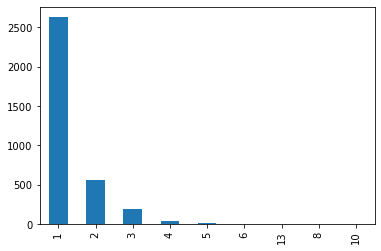

In [11]:
data.groupby(['users', 'cities']).size().value_counts().plot.bar();

- Let's also check how many hotels there are in each city:

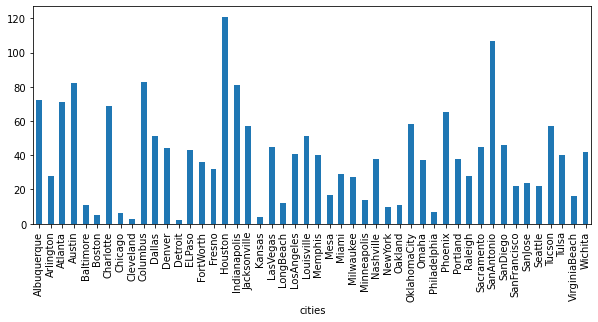

In [12]:
data.groupby('cities')['hotels'].nunique().plot.bar(figsize=(10,4));

- We see that
  - there are many hotels in each city,
  - but users mostly prefer staying in a unique hotel withing a city.
- We can conclude that users indeed have individual preferences on which specific hotel to stay in.
- This is an important information for understanding the recommendation scenario.
- The recommender system goal can be formulated as:  
  - **Knowning the previous cities and hotels a user has visited,**
  - **predict which hotel the user will likely visit in a new city**.

Let's prepare our data accordingly to realize such recommendation scenario.  

## Preparing data splits

- First of all, let's sample candidate test users.
- It will be users who have visited at most 1 hotel (at least in some cities).
  - That way we can exclude scenario corresponding to the prediction of another hotel **within the same city**.
  - We will always predict a hotel **within a new city**.
- The intuition behind this scenario:
  - we want to help users to find a good hotel in a city they have **never been before**.
- Other scenarios are also possible (and they will inform a different data splitting), but let's focus on this one.
- Note that such preprocessing doesn't mean there will be no users with more than 1 hotel in the same city in the training data.
  - The selection criteria is only applied to the holdout construction.

In [13]:
user_city_to_sample = (
    data
    # select user-city pairs based on hotels count
    .groupby(['users', 'cities'])
    .size()
    # hotels count must be exactly 1 according to our scenario
    .pipe(lambda x: x.index[x==1])
)

In [14]:
user_city_to_sample[:5]

MultiIndex([(45, 'Albuquerque'),
            (45,      'ELPaso'),
            (45,     'Memphis'),
            (64,      'Austin'),
            (64,   'Cleveland')],
           names=['users', 'cities'])

- We also need to sample users with more than one city in hotel-visiting history.
- Otherwise, after holdout splitting, we will have to deal with cold-start cases, which is not the purpose of this task.

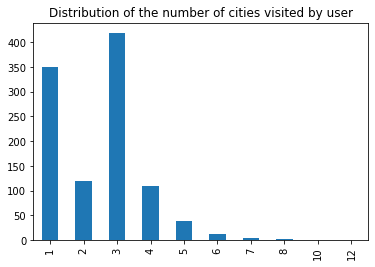

In [15]:
user_cities_df = pd.DataFrame.from_records(user_city_to_sample, columns=['users', 'cities'])
user_cities_df.groupby('users').size().value_counts().sort_index().plot.bar(
    title="Distribution of the number of cities visited by user"
);

- Clearly, there are many users with only one city visited.
- We need to exclude them, as they would correspond to the cold start recommendations scenario:

In [16]:
users_with_more_cities = (
    user_cities_df
    .groupby('users')
    ["cities"]
    .apply(list)
    # exclude 'single-city' users
    .loc[lambda x: x.apply(len)> 1]
)
len(users_with_more_cities)

710

In [17]:
users_with_more_cities.head()

users
45                        [Albuquerque, ELPaso, Memphis]
64                          [Austin, Cleveland, Houston]
100    [Albuquerque, Dallas, Indianapolis, Jacksonville]
159                        [ELPaso, Houston, Louisville]
198                [ELPaso, LosAngeles, Phoenix, Tucson]
Name: cities, dtype: object

### Splitting into validation and test

- For simplicity, we ignore any sequential component in user behavior (we do not have timestamps or any other order-related information anyway)
- Hence, let's just randomly split test users into validation and test segments and then randomly sample holdout items.

In [18]:
valid_user_city_candidates = users_with_more_cities.iloc[::2]
test_user_city_candidates = users_with_more_cities.iloc[1::2]
# check the number of users
len(valid_user_city_candidates), len(test_user_city_candidates)

(355, 355)

In [19]:
valid_user_city_candidates.head()

users
45                        [Albuquerque, ELPaso, Memphis]
100    [Albuquerque, Dallas, Indianapolis, Jacksonville]
198                [ELPaso, LosAngeles, Phoenix, Tucson]
221              [Arlington, Boston, Fresno, LosAngeles]
451                          [Columbus, Phoenix, Tucson]
Name: cities, dtype: object

- We won't be testing our recommender against the warm start scenario (our dataset is too small for that).
- Hence, we will just hide a single holdout item per test user and the remaining part will be returned back into the training data.

In [20]:
def sample_user_city_pairs(series, random_state):
    pairs = (
        series
        .explode()
        # shuffle data
        .sample(frac=1, random_state=random_state)
        # select a single city per user
        .groupby(level='users')
        .first()
        .reset_index()
    )
    return pairs

random_state = np.random.RandomState(99)
validation_examples = sample_user_city_pairs(valid_user_city_candidates, random_state)
test_examples = sample_user_city_pairs(test_user_city_candidates, random_state)

In [21]:
validation_examples.head()

,users,cities
0,45,Memphis
1,100,Albuquerque
2,198,ELPaso
3,221,Boston
4,451,Tucson


- The next step is to mark validation and test examples within the source dataset.
- That way we can safely split it into training, validation, and test parts.
- Remember that after validation stage, the validation and training data should be merged back.

In [22]:
marked_data = pd.merge(
    pd.merge(
        data,
        validation_examples,
        how = 'left',
        on = ["users", "cities"],
        indicator = "merge_valid"
    ),
    test_examples,
    how = 'left',
    on = ["users", "cities"],
    indicator = "merge_test"
)    
marked_data.head(10)

,users,hotels,cities,merge_valid,merge_test
0,45,105170,Memphis,both,left_only
1,45,223229,SanAntonio,left_only,left_only
2,45,258688,Albuquerque,left_only,left_only
3,45,98827,ELPaso,left_only,left_only
4,45,99518,SanAntonio,left_only,left_only
5,64,224427,Cleveland,left_only,left_only
6,64,1751886,Austin,left_only,both
7,64,99120,Houston,left_only,left_only
8,100,120111,Jacksonville,left_only,left_only
9,100,91428,Indianapolis,left_only,left_only


- Here's the splitting:

In [23]:
valid_holdout_ = marked_data.query('merge_valid == "both"')
test_holdout_ = marked_data.query('merge_test == "both"')
train_data_ = marked_data.query('merge_valid == "left_only" and merge_test == "left_only"')

Recall,
- validation data is used for fine-tuning,
- test data is used for final evaluation and comparison of different models.

### Reindexing data

- As we now have three variables - users, hotels, and cities - we need to update the `transform_indices` function we used previously.
  - It must accept contextual information along with users and items:

In [24]:
def transform_indices_3D(data, users, hotels, cities):
    data_index = {}
    for entity, field in zip(['users', 'hotels', 'cities'], [users, hotels, cities]):
        idx, idx_map = to_numeric_id(data, field)
        data_index[entity] = idx_map
        data.loc[:, field] = idx
    return data, data_index

In [25]:
train_data, data_index = transform_indices_3D(train_data_.copy(), 'users', 'hotels', 'cities')

In [26]:
valid_holdout = reindex(valid_holdout_, data_index.values(), filter_invalid=True)
test_holdout = reindex(test_holdout_, data_index.values(), filter_invalid=True)

Filtered 70 invalid observations.
Filtered 62 invalid observations.


In [27]:
valid_holdout.shape, test_holdout.shape

((285, 5), (293, 5))

In [28]:
data_description = dict(
    users = data_index['users'].name,
    hotels = data_index['hotels'].name,
    cities = data_index['cities'].name,
    feedback = None, # we will ignore rating information
    n_users = len(data_index['users']),
    n_hotels = len(data_index['hotels']),
    n_cities =  len(data_index['cities']),
)
data_description

{'users': 'users',
 'hotels': 'hotels',
 'cities': 'cities',
 'feedback': None,
 'n_users': 1202,
 'n_hotels': 1764,
 'n_cities': 48}

To recap this phase,
- our holdout data contains user-hotel-city triplets
- by construction, for each holdout hotel, there are no other hotels visited by a user in the same city

# Building context-aware TF model

- Now it's you turn to write some code:
  - in subsequent cells, you'll see some incomplete lines of code,
  - cells won't execute until you complete them,
- Use your knowledge and understanding of the task (hints will be provided as well).

But first, let's see what is the density of our 3D tensor (i.e., the amount of known entries).  

**Complete the code below (5 pts):**

In [35]:
train_data_density = train_data.shape[0] / \
    (train_data['users'].nunique() * train_data['cities'].nunique() * train_data['hotels'].nunique())
print(f"Data density = {train_data_density:.3%}")

Data density = 0.004%


Think, how this density can impact the ability of models to learning meaningful representations.

## Model training

- As we've already discussed, we wil build a tensor factorization (TF) model.
- As in all previous cases, TF will be implemented based on the Higher Order Orthogonal Iteration algorithm (HOOI).
- Use previously shared code for the CoFFee model for reference.

**Complete the model training function (20 pts):**

In [52]:
def context_tf_model_build(config, data, data_description):
    userid = data_description["users"]
    itemid = data_description["hotels"]
    cityid = data_description["cities"]

    n_users = data_description["n_users"]
    n_items = data_description["n_hotels"]
    n_cities = data_description["n_cities"]
    shape = (n_users, n_items, n_cities)

    idx = data[[userid, itemid, cityid]].values
    val = np.ones(idx.shape[0], dtype='f8')

    user_factors, item_factors, city_factors, core = hooi(
        idx, val, shape, config["mlrank"],
        parallel_ttm = False,
        growth_tol = 0.001,
        seed = config["seed"]
    )
    
    return user_factors, item_factors, city_factors


In [53]:
hooi.__doc__

'\n    Compute Tucker decomposition of a sparse tensor in COO format\n    with the help of HOOI algorithm. Usage:\n    u0, u1, u2, g = hooi(idx, val, shape, core_shape)\n    '

In [54]:
config = {
    "mlrank": (15, 15, 2),
    "num_iters": 2,
    "seed": 42
}

In [55]:
tf_params = context_tf_model_build(config, train_data, data_description)

- Note that the number of ALS iterations in this implementation is predefined and fixed during procedure.
- The stopping criteria is based on on estimation of the prediction error improvement.
- It may not be the best strategy for learning a good model:
  - recall, our optimization objective (error minimization) is not exactly related to the actual evaluation metric (e.g., HR or MRR).
  - **Suggest a modification to the training procedure** to make it more aligned with the evaluation target.
    - **Write your answer below.** No code required, only conceptual answer. (10 pts)

## Validation stage

We will need some additional information to run scoring and recommendation generation functions more conveniently.

- According to our recommendations scenario:
  - we need to provide information about target context into the scoring function;
  - the context in our case is a city where a hotel from holdout is located.
    - Note, **we never expose holdout item**, we only provide contextual information to inform our context-aware model.
- We will store this information in the `data_description` variable for convenience.

In [56]:
data_description['target_cities'] = valid_holdout.set_index('users')['cities']
data_description['target_cities'].head()

users
0     24
2      0
5     13
7      5
10    44
Name: cities, dtype: int64

- We also need to know which hotels are present in a city.
  - When scoring, we will compute scores only for these hotels.  
- Conversely, computing scores for entire hotel catalog is a redundant task:
  - in our scenario, when generating recommendations, we know that a user is looking for a hotel in a specific city,
  - there's no point in recommending hotels outside of that city.


In [65]:
data_description["city_hotels"] = (
    train_data
    .groupby('cities')
    ['hotels']
    .unique()
)
data_description["city_hotels"].head()

cities
0    [1352, 955, 586, 425, 412, 422, 568, 587, 1600...
1    [1636, 858, 1627, 862, 1608, 1207, 1240, 979, ...
2    [1561, 324, 1065, 266, 1063, 1055, 271, 332, 3...
3    [831, 1342, 553, 1630, 1625, 1590, 816, 808, 8...
4    [989, 1383, 1180, 1623, 313, 315, 1741, 653, 1...
Name: hotels, dtype: object

- When generating prediction scores, we use a higher order folding-in technique over $hotels \times cities$ user preferences matrix $P$.
- Folding-in in our case is basically a double projector over the latent space of hotels ($V$) and cities ($W$) acting on $P$:  
    $$R = VV^\top P\,WW^\top$$

- Hence, we need to know previously visited hotels of a test user and their corresponding cities in order to construct a user preferences matrix:

In [66]:
data_description['visited_hotels'] = (
    train_data
    .query('users in @valid_holdout["users"]')
    .groupby('users')
    ['hotels']
    .apply(list)
)
data_description['visited_hotels'].head()

users
0     [1106, 1352, 602, 650]
2            [930, 339, 854]
5              [60, 78, 211]
7           [1636, 100, 211]
10               [1619, 482]
Name: hotels, dtype: object

- Finally, after we found previously visited hotels we also need to know the cities they're located in. 
- By construction, the mapping between hotels and cities is unambiguous, i.e. each hotel id corresponds to a unique city.
- Let's add this mapping to `data_description`:

In [67]:
data_description['holtel_city_mapping'] = (
    train_data
    .drop_duplicates(subset=["hotels", "cities"])
    .set_index("hotels")
    ["cities"]
)
data_description['holtel_city_mapping'].head()

hotels
1106    39
1352     0
602     13
650     39
1205     8
Name: cities, dtype: int8

### Scoring

- Note that the scoring is performed for the hotels within the specified target city for each test user.
- That means that you don't need to compute scores for all possible pairs of cities and hotels.
- When performed on a per-user basis (in the loop), the higher order folding-in simplifies to a series of matrix-vector products from right to left (think why).

Based on the description above, your task now is to **complete the scoring function**. (20 pts)

In [77]:
def tf_scoring(params, data, data_description):
    '''Returns a dictionary of scores for hotels within target city per each test user'''
    user_factors, hotel_factors, city_factors = params
    
    n_hotels = hotel_factors.shape[0]
    n_cities = city_factors.shape[0]
    
    # check visited hotels, get their city info -> use it to build user preferences matrix
    test_user_hotels = data_description["visited_hotels"]
    hotel_city_mapping = data_description["holtel_city_mapping"]
    # get target city for a test user, find all hotels in this city -> compute scores for them
    test_user_city = data_description["target_cities"]
    city_hotels = data_description["city_hotels"]

    user_scores = {}
    for user, user_hotels in test_user_hotels.items():
        user_cities = hotel_city_mapping[user_hotels]
        p_matrix = csr_matrix(
            (
                [1] * len(user_hotels),
                (user_hotels, user_cities)
            ),
            (n_hotels, n_cities)
        )

        target_city = test_user_city[user]
        hotels_to_score = city_hotels[target_city]
        target_city_factors = city_factors[target_city]
        target_hotels_factors = hotel_factors[hotels_to_score]
        # recommendations are generated via higher-order folding-in 
        # the most efficient way to compute it is by multiplying from right to left
        # that way it's just a series of matrix-vector products
        predicted_scores = target_hotels_factors @ (hotel_factors.T @ (p_matrix * (city_factors @ target_city_factors.T)))
        user_scores[user] = predicted_scores
    return user_scores

- Note that we skipped the downvoting step that we previously used in our pipelines.
  - In other words, we do not attempt to filter out previously visited hotel from recommendations.
- Do we actually need this step? **Explain your answer.** (5 pts)

In [78]:
tf_scores = tf_scoring(tf_params, None, data_description)

### Generating recommendations

In [79]:
def topn_recommendations(scores_dict, topn=2):
    '''
    Returns a dict of ids corresponding to the top-scored elements per each test user.
    Note that these ids are not the actual item ids, as the `scores_dict`
    contains a varying number of elements per each test user. Hence, `topidx` function
    returns "reduced" ids, i.e. positions within the list of elements, not within the entire item catalog.
    '''
    return {user: topidx(scores, topn) for user, scores in scores_dict.items()}

- We have limited our top-$n$ recommendations to $n=2$.
- **Explain, why increasing $n$ would be problematic.** (5 pts)

In [80]:
tf_recs = topn_recommendations(tf_scores)

### Model evaluation

- We also need to rewrite evaluation function in order to comply with the format of the generated scores.
- You don't need to complete any lines of code in the evaluation function.

In [81]:
def evaluate(recs_dict, holdout, data_description):
    '''
    Runs over a dict of recommendations and aggregates hits.
    Takes into account the fact that "reduced" ids from `recs_dict` must be translated
    to the actual item ids.  
    '''
    rr = 0
    hits = 0
    rec_items = set()
    userid = data_description["users"]
    cityid = data_description["cities"]
    hotelid = data_description["hotels"]
    
    city_hotels = data_description["city_hotels"]
    iter_data = holdout[[userid, hotelid, cityid]]
    for user, target_hotel, target_city in iter_data.itertuples(name=None, index=False):
        # get indices of the scored items, e.g. hotels within the target city
        scored_hotels = city_hotels[target_city] # complete the code
        # translate "reduced" index into actual item id 
        user_recs = np.take(scored_hotels, recs_dict[user])
        # compute metrics by comparing recommendations with the holdout
        hits_pos, = np.where(user_recs == target_hotel)
        if len(hits_pos):
            hits += 1
            rr += 1 / (hits_pos.item()+1)
        rec_items = rec_items.union(user_recs)
    n_users = holdout.shape[0]
    mrr = rr / n_users
    hr = hits / n_users
    n_items = data_description["n_hotels"]
    cov = len(rec_items) / n_items
    return hr, mrr, cov

In [82]:
print('HR={:.4f}, MRR={:.4f}, COV={:.4f}'.format(*evaluate(tf_recs, valid_holdout, data_description)))

HR=0.0772, MRR=0.0596, COV=0.1627


### Fine-tuning with grid search

In [83]:
from polara.evaluation.pipelines import random_grid

- You will use a simple grid of multilinear rank values for tuning your model.
- The easiest way to construct the grid is by utilizing `polara`'s `random_grid` function.
- It takes a dictionary of hyper-parameters values and returns a (sampled) cartesian product giving all possible configurations.

Here's how it can be done:

In [84]:
tf_hyper = { # hyper-parameters dict for multi-linear rank
    'r1': range(5, 41, 5), # users space rank
    'r2': range(5, 41, 5), # hotels space rank
    'r3': range(5, 21, 5), # cities space rank
}

In [85]:
def valid_mlrank(mlrank):
    '''
    Only allow ranks that are suitable for truncated SVD computations
    on unfolded compressed tensor (the result of ttm product in HOOI).
    '''
    r1, r2, r3 = mlrank
    return r1*r2 > r3 and r1*r3 > r2 and r2*r3 > r1

# constructing the grid
grid, param_names = random_grid(tf_hyper, n=0) # n=0 means all points, no random sampling
# ensuring the preserved order of hyper-parameters values
assert param_names == ('r1', 'r2', 'r3')
# allowing only valid rank configurations
tf_grid = [tuple(mlrank) for mlrank in grid if valid_mlrank(mlrank)]

print(f'Total number of grid configurations: {len(tf_grid)}')

Total number of grid configurations: 248


In [91]:
data_description.keys()

dict_keys(['users', 'hotels', 'cities', 'feedback', 'n_users', 'n_hotels', 'n_cities', 'target_cities', 'city_hotels', 'visited_hotels', 'holtel_city_mapping'])

In [92]:
hr_tf = {}
mrr_tf = {}
cov_tf = {}
for mlrank in track(tf_grid):
    config['mlrank'] = mlrank
    tf_params = context_tf_model_build(config, train_data, data_description)
    tf_scores = tf_scoring(tf_params, None, data_description)
    tf_recs = topn_recommendations(tf_scores)
    hr, mrr, cov = evaluate(tf_recs, valid_holdout, data_description)
    hr_tf[mlrank] = hr
    mrr_tf[mlrank] = mrr
    cov_tf[mlrank] = cov

 [████████████████████████████████████████████████████████████] 248/248 [01:39<00:01, 0.40s/it]

In [93]:
print(f'Best HR={pd.Series(hr_tf).max():.4f} achieved with mlrank={pd.Series(hr_tf).idxmax()}')
print(f'Best MRR={pd.Series(mrr_tf).max():.4f} achieved with mlrank={pd.Series(mrr_tf).idxmax()}')

Best HR=0.1263 achieved with mlrank=(5, 20, 10)
Best MRR=0.1000 achieved with mlrank=(5, 20, 10)


In [94]:
print(f'COV={pd.Series(cov_tf)[pd.Series(hr_tf).idxmax()]:.4f} (based on best HR value)')

COV=0.1224 (based on best HR value)


## Remarks

- We won't use data normalization here.
  - However, you can easily extend the model yourself using the code from the lecture on Sequential Tensor Factorization.

# Baselines

**Complete the code for training and evaluating three baseline models:**
- random recommendations, (5 pts)
- popularity-based recommendations, (5 pts)
- PureSVD. (10 pts)

## Random model

In [98]:
def build_rnd_model(config, data, data_description):
    return np.random.RandomState(config["seed"])

def rnd_model_scoring(params, data, data_description):
    random_state = params
    # check visited hotels, get their city info -> use it to build user preferences matrix
    test_user_hotels = data_description["visited_hotels"]
    # get target city for a test user, find all hotels in this city -> compute scores for them
    test_user_city = data_description["target_cities"]
    city_hotels = data_description["city_hotels"]

    user_scores = {}
    for user, user_hotels in test_user_hotels.items():
        target_city = test_user_city[user]
        hotels_to_score = city_hotels[target_city]
        # recommendations are generated via higher-order folding-in
        predicted_scores = random_state.rand(len(hotels_to_score))
        user_scores[user] = predicted_scores
    return user_scores

In [99]:
rnd_params = build_rnd_model({'seed': 0}, None, data_description)
rnd_scores = rnd_model_scoring(rnd_params, None, data_description)
rnd_recs = topn_recommendations(rnd_scores)
print('HR={:.4f}, MRR={:.4f}, COV={:.4f}'.format(*evaluate(rnd_recs, valid_holdout, data_description)))

HR=0.0596, MRR=0.0474, COV=0.2800


## Popularity-based

In [101]:
def build_pop_model(config, data, data_description):
    cityid = data_description["cities"]
    hotelid = data_description["hotels"]
    popularity = train_data[hotelid].value_counts()
    return popularity

def pop_model_scoring(params, data, data_description):
    popularity = params
    # check visited hotels, get their city info -> use it to build user preferences matrix
    test_user_hotels = data_description["visited_hotels"]
    # get target city for a test user, find all hotels in this city -> compute scores for them
    test_user_city = data_description["target_cities"]
    city_hotels = data_description["city_hotels"]

    user_scores = {}
    for user, user_hotels in test_user_hotels.items():
        target_city = test_user_city[user]
        hotels_to_score = city_hotels[target_city]
        # recommendations are generated via higher-order folding-in
        predicted_scores = popularity[hotels_to_score]
        user_scores[user] = predicted_scores.values
    return user_scores

In [102]:
pop_params = build_pop_model(None, train_data, data_description)
pop_scores = pop_model_scoring(pop_params, None, data_description)
pop_recs = topn_recommendations(pop_scores)
print('HR={:.4f}, MRR={:.4f}, COV={:.4f}'.format(*evaluate(pop_recs, valid_holdout, data_description)))

HR=0.1193, MRR=0.0947, COV=0.0533


## PureSVD

In [119]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['hotels']]
    values = np.ones(len(useridx), dtype='f8')
    return csr_matrix((values, (useridx, itemidx)), dtype='f8')


def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    _, s, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors, singular_values


def svd_model_scoring(params, data, data_description):
    hotel_factors, sigma = params    
    n_hotels = hotel_factors.shape[0]
    
    # check visited hotels, get their city info -> use it to build user preferences matrix
    test_user_hotels = data_description["visited_hotels"]
    # get target city for a test user, find all hotels in this city -> compute scores for them
    test_user_city = data_description["target_cities"]
    city_hotels = data_description["city_hotels"]

    user_scores = {}
    for user, user_hotels in test_user_hotels.items():
        target_city = test_user_city[user]
        hotels_to_score = city_hotels[target_city]
        target_hotels_factors = hotel_factors[hotels_to_score]
        # recommendations are generated via higher-order folding-in
        
        train_matrix = matrix_from_observations(data, data_description)
        
        predicted_scores = np.squeeze(train_matrix[user] @ hotel_factors @ target_hotels_factors.T)
        user_scores[user] = predicted_scores
    return user_scores    

### SVD grid-search

In [120]:
svd_rank_grid = range(5, 41, 5)

hr_svd = {}
mrr_svd = {}
cov_svd = {}
for rank in svd_rank_grid:
    svd_config = {'rank': rank}
    svd_params = build_svd_model(svd_config, train_data, data_description)
    svd_scores = svd_model_scoring(svd_params, train_data, data_description)
    svd_recs = topn_recommendations(svd_scores)
    hr, mrr, cov = evaluate(svd_recs, valid_holdout, data_description)
    hr_svd[rank] = hr
    mrr_svd[rank] = mrr
    cov_svd[rank] = cov

In [121]:
print(f'Best HR={pd.Series(hr_svd).max():.4f} achieved with mlrank={pd.Series(hr_svd).idxmax()}')
print(f'Best MRR={pd.Series(mrr_svd).max():.4f} achieved with mlrank={pd.Series(mrr_svd).idxmax()}')

Best HR=0.1263 achieved with mlrank=5
Best MRR=0.1070 achieved with mlrank=5


In [122]:
print(f'COV={pd.Series(cov_svd)[pd.Series(hr_svd).idxmax()]:.4f} (based on best HR value)')

COV=0.1202 (based on best HR value)


# Final test stage

**Write your own code to**:
- perform final evaluation of models,
- recompute all models metrics w.r.t the test holdout,
- report your results and provide conclusion on effectiveness of the tensor model and ways for improving it.


Full completion of this task is worth 15 pts.

### TF 

In [160]:
results_dict = {}

In [221]:
config = {
    "mlrank": (5, 20, 10),
    "num_iters": 2,
    "seed": 42
}

tf_params = context_tf_model_build(config, train_data, data_description)
tf_scores = tf_scoring(tf_params, None, data_description)
tf_recs = topn_recommendations(tf_scores)

out = evaluate(tf_recs, valid_holdout, data_description)

results_dict['TF'] = out

print('HR={:.4f}, MRR={:.4f}, COV={:.4f}'.format(*out))

HR=0.1404, MRR=0.1088, COV=0.1173


### Random

In [222]:
rnd_params = build_rnd_model({'seed': 0}, None, data_description)
rnd_scores = rnd_model_scoring(rnd_params, None, data_description)
rnd_recs = topn_recommendations(rnd_scores)

out = evaluate(rnd_recs, valid_holdout, data_description)

results_dict['Random'] = out

print('HR={:.4f}, MRR={:.4f}, COV={:.4f}'.format(*out))

HR=0.0596, MRR=0.0474, COV=0.2800


### Popularity-based

In [223]:
pop_params = build_pop_model(None, train_data, data_description)
pop_scores = pop_model_scoring(pop_params, None, data_description)
pop_recs = topn_recommendations(pop_scores)

out = evaluate(pop_recs, valid_holdout, data_description)

results_dict['Pop-based'] = out

print('HR={:.4f}, MRR={:.4f}, COV={:.4f}'.format(*out))

HR=0.1193, MRR=0.0947, COV=0.0533


### PureSVD

In [224]:
svd_config = {'rank': 5}
svd_params = build_svd_model(svd_config, train_data, data_description)
svd_scores = svd_model_scoring(svd_params, train_data, data_description)
svd_recs = topn_recommendations(svd_scores)

out = evaluate(svd_recs, valid_holdout, data_description)

results_dict['PureSVD'] = out

print('HR={:.4f}, MRR={:.4f}, COV={:.4f}'.format(*out))

HR=0.1263, MRR=0.1070, COV=0.1202


In [225]:
results_df = pd.DataFrame(results_dict, index=['HR', 'MRR', 'COV'])
results_df

,TF,Random,Pop-based,PureSVD
HR,0.140351,0.059649,0.119298,0.126316
MRR,0.108772,0.047368,0.094737,0.107018
COV,0.117347,0.280045,0.053288,0.120181


In [226]:
results_df.idxmax(axis=1)

HR         TF
MRR        TF
COV    Random
dtype: object

# Corollary

As we can see, TF permorms best, however its not stable as it outputs different metrics. From the other side, it beats the rest of the approaches, and i also could assume, that if we will consider more dimensions, eg. trip type, it will imply more contextual information, which probably could affect our recommendations quality. Also its preddy expected, that Random model provides best coverage.